# SYDE 552 Assignment 1: Neuron Models
### Due Monday, January 29, 11:59pm
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with neuron models of various complexitites. To do so, we'll be using the BRIAN2 neural simulator, a Python library for creating arbitrary spiking neuron models by defining the underlying equations. We'll provide a basic tutorial for BRIAN that should include everything needed to do this assigment, but for additional help and existing neuron implmenetations, see the links below. 

Work in groups of 1-2 people. Your code should be original, but you can borrow ideas and equations from these sources when building your models (please note when you do). Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

Additional sources
 - Equations: Dayan and Abbott Ch.5-6, Gerstner et al Ch.1-2
 - BRIAN2 documentation: https://brian2.readthedocs.io/en/stable/index.html
 - Working examples: https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html, https://brian2.readthedocs.io/en/stable/user/multicompartmental.html, https://neuronaldynamics-exercises.readthedocs.io/en/latest/

# Install and Import Libraries


Install BRIAN2 (https://brian2.readthedocs.io/en/stable/introduction/install.html). You'll also need jupyter, numpy, scipy, and matplotlib. I reccomend using ```pip``` to install everything: from a terminal, run

```pip install brian2```

```pip install jupyter numpy scipy matplotlib```


open this jupyter notebook with 

```jupyter notebook syde552assigment1.ipynb```

In [2]:
import numpy as np
import scipy
from brian2 import *
import matplotlib.pyplot as plt

# Intro to BRIAN2 (integrate-and-fire models)
BRIAN uses a unit system to give the constants in neuron equations appropriate physical dimensions

In [2]:
v_demo = -65*mV  # voltage
print(v_demo)

-65. mV


BRIAN does unit combinations, but will tell you when units don't match up

In [3]:
r_demo = 10*ohm  # resistance
i_demo = v_demo/r_demo  # calculate current
print(i_demo)

-6.5 mA


In [4]:
#v_demo + i_demo  # volts + amps = (invalid) - should produce a DimensionMismatchError

Equations are written as strings, adding a ```: unit``` at the end

In [5]:
tau = 10*ms
eqn = '''dv/dt = -v/tau : mV'''

Note that ```mV``` describes the unit for the new variable ```v``` that is being defined by the equation, not the quantity on the left-hand-side (which would here be mV/s).

If you want to have the variable be unitless, you can type ```: 1```.

In [6]:
eqn = '''
dv/dt = (1-v)/tau: 1  # leak towards v_eq=1 
'''

Create a neuron by defining an "ensemble" (population) of neurons

In [7]:
ens = NeuronGroup(1, eqn, method='exact')  # n=1 neurons in the population, "exact" numerical integration

Set up a probe to record state variables from neurons in ```ens```

In [8]:
p = StateMonitor(ens, 'v', record=True)

Run the simulation

In [9]:
run(100*ms)

Plot the result

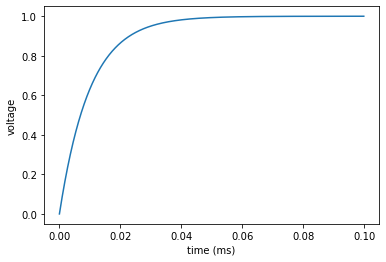

In [10]:
fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.show()

Now let's add in a spiking mechanism, which includes a "threshold" and a "reset" mechanism.

The ```threshold``` block defines the condition which must be met to register a "spike".

The ```reset``` block defines what happens when a spike occurs.

Before we start, let's explicitly create a scope for this particular model. This avoids accidentally carrying over from variables / constants defined earlier in the notebook.

In [11]:
start_scope()

tau = 10*ms
v_target = 10*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''dv/dt = (v_target - v)/tau : volt'''

ens = NeuronGroup(1, eqn, threshold='v>theta', reset='v = v_reset', method='euler')

Notice that we started using real units, and changed our numerical integration scheme to a simple numerical solver (Euler's Method)

We also need to define a new type of probe to collect spikes

In [12]:
p = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

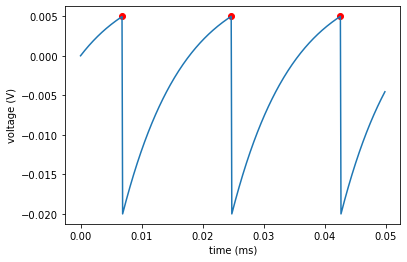

In [13]:
run(50*ms)

fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])
ax.scatter(p_s.t, theta*np.ones((len(p_s.t))), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.show()

Reset and refractory mechanisms can also be specified as complex expressions, each defined by its own string.

We'll add a unitless state variable ```a``` that is incremented when a spike occurs, and increases the spike threshold and the refractor period

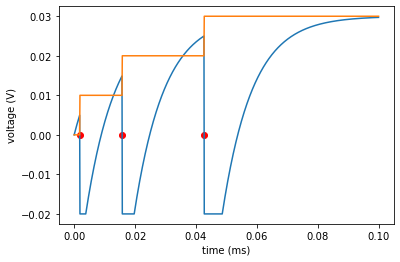

In [14]:
start_scope()

tau = 10*ms
v_target = 30*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''
dv/dt = (v_target - v)/tau : volt  (unless refractory)
a : 1  # unitless
'''

thr = '''v > theta + a*volt'''  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.01
'''

ref = '''a*200*ms'''

ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method='euler')

p_v = StateMonitor(ens, 'v', record=True)
p_a = StateMonitor(ens, 'a', record=True)
p_s = SpikeMonitor(ens)

run(100*ms)

fig, ax = plt.subplots()
ax.plot(p_v.t, p_v.v[0])
ax.plot(p_a.t, p_a.a[0])
ax.scatter(p_s.t, np.zeros((p_s.t.shape)), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.show()

# Question 1: LIF Neuron

## 1.1 [2 points] Implement the LIF neuron. Simulate the neuron with a 2mA external current. Plot voltage vs time.

#### Equations: 
$\frac{dV}{dt} = -\frac{1}{RC}(V - E_{leak}) + \frac{1}{C}I_{ext}$

if $V>V_{thr}$:
- set $V=V_{reset}$
- begin a refractory period of $\tau_{ref}$ ms
 
#### Constants:
 - $R = 10$ ohm
 - $C = 1$ mfarad
 - $\tau_{ref} = 2$ ms
 - $E_{leak} = -65$ mV
 - $V_{thr} = -50$ mV
 - $V_{reset} = -80$ mV
 - $I_{ext} = 2$ mA
 
#### Notes
 - set state variables using ```ens.v = v_initial```

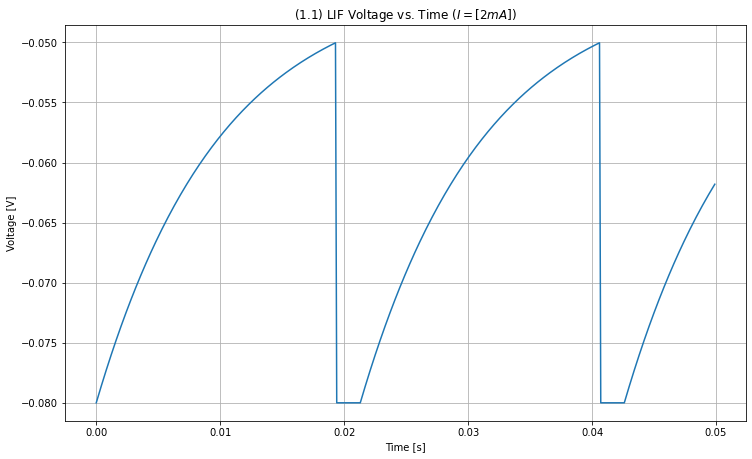

In [15]:
start_scope()
# Initialize Neuron + Simulation Parameters
R_n = 10*ohm
C_n = 1*mfarad
tau_ref_n = 2*ms
E_leak = -65*mV
V_th = -50*mV
V_res = -80*mV
I_ext = 2*mA

# Initialize Behaviour Eqns for Neuron Behaviour
n_eq = 'dv/dt = -(1/(R_n*C_n))*(v - E_leak) + (1/C_n)*I_ext : volt (unless refractory)'
thresh = 'v > V_th'
reset = 'v = V_res'
ref = 'tau_ref_n'

# Create Neuron and Initialize Voltage to the Reset Voltage
ens = NeuronGroup(1, n_eq, threshold=thresh, reset=reset, refractory=ref, method='euler')
ens.v = -80*mV

# Configure Probes to Track Neuron Properties
p_voltage = StateMonitor(ens, 'v', record=True)
p_spike = SpikeMonitor(ens)

# Create Reload Point for Successive Simulations
store('init')

# Simulate
run(50*ms)

# Visualize
fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(top=1.5,right=1.7,wspace=0.3,hspace=0.2)    
pl1.plot(p_voltage.t, p_voltage.v[0])
pl1.set(title="(1.1) LIF Voltage vs. Time ($I=[2mA]$)", xlabel='Time [s]', ylabel='Voltage [V]')
pl1.grid()
plt.show()

## 1.2 [2 points] Create response curves for the LIF neuron
 - (a) Inject a constant test current into the neuron, run the simulation, and count the number of spikes. Repeat this for a variety of test currents, then plot average firing rate (spikes/second) versus input current.
 - (b) Choose a new value of R or C, run the experiment from (a) again, and add the new response curve to your plot
 - (c) Choose a new value of tau_ref, run the experiment from (a) again, and overlay the new resopnse curve to your plot

#### Parameters
- Test currents: 1-20mA in increments of 0.5mA
- Simulation duration: $200$ms

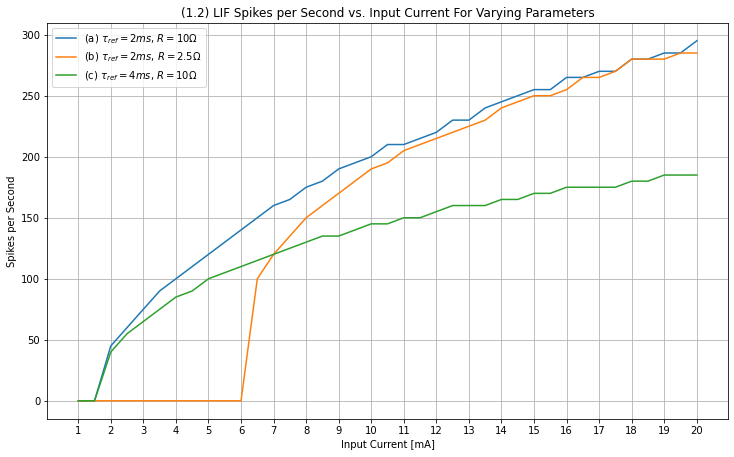

In [16]:
# Implement Probe to Track Neuron Spikes 
sim_time = 200*ms

# Basic response function that returns the spike frequency (# spikes per second)
def LIF_response(I=2*mA, R=10*ohm, C=1*mfarad, tau_ref=2*ms):
    R_n = R
    C_n = C
    I_ext = I
    tau_ref_n = tau_ref
    run(sim_time)
    spike_frq = p_spike.num_spikes/sim_time
    return spike_frq
    
# Initialize Visualization Objects
fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(top=1.5,right=1.7,wspace=0.3,hspace=0.2)    

# Initialize Variable Current Range, Run Simulations, and Visualize Results
I_set = np.arange(1,20.5,0.5)*mA
spikes_a = np.zeros_like(I_set)
for I_i in range(len(I_set)):
    restore('init')
    spikes_a[I_i] = LIF_response(I=I_set[I_i])
pl1.plot(I_set*1000,spikes_a,label="(a) $\\tau_{ref}=2ms$, $R=10\Omega$")

# Reduce Leaking Resistance to 2.5[Ohms] and Repeat Variable Current Simulation and Visualization
R_new = 2.5*ohm
spikes_b = np.zeros_like(I_set)
for I_i in range(len(I_set)):
    restore('init')
    spikes_b[I_i] = LIF_response(I=I_set[I_i],R=R_new)
pl1.plot(I_set*1000,spikes_b,label="(b) $\\tau_{ref}=2ms$, $R=2.5\Omega$")

# Increase Refractory Time to 4[ms] and Repeat Variable Current Simulation and Visualization
tau_ref_new = 4*ms
spikes_c = np.zeros_like(I_set)
for I_i in range(len(I_set)):
    restore('init')
    spikes_c[I_i] = LIF_response(I=I_set[I_i],tau_ref=tau_ref_new)
pl1.plot(I_set*1000,spikes_c,label="(c) $\\tau_{ref}=4ms$, $R=10\Omega$")
pl1.set(title="(1.2) LIF Spikes per Second vs. Input Current For Varying Parameters", xlabel='Input Current [mA]', ylabel='Spikes per Second')

# Adjust Plot Properties and Visualize
pl1.set_xticks(np.arange(1,21,step=1))
pl1.grid()
pl1.legend()
plt.show()

## 1.3 [2 points] Add an adaptation term to the LIF neuron. Calculate the inter-spike-interval and plot it versus spike number to demonstrate adaptation.
 - Inter-spike-interval (ISI) is defined as the length of time between two spikes. To calculate it, compute the difference between the spike times returned from a BRIAN spike monitor
   - tip: use ```np.diff()```
 - Plot the resulting array of values as a scatter plot: $y$ values will be ISI in ms, and $x$ values will range from $1$ to $C$, the spike count value at the end of the simulation.

#### Additional Equations
$\frac{da}{dt} = -\frac{a}{\tau_a}$

$v_{thr} = -50mV + a$

if $v > v_{thr}$:
  - $a = a + \Delta A$
  
#### Additional Constants
- $I_{ext} = 2$mA
- $\tau_a = 100$ ms
- $\Delta A = 1$ mV
- runtime = 500 ms

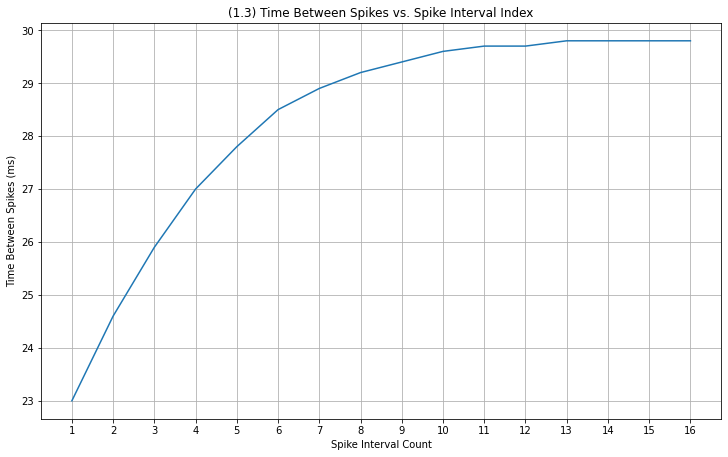

In [17]:
start_scope()
# Initialize Neuron + Simulation Parameters (Change to model requires new Neuron)
R_n = 10*ohm
C_n = 1*mfarad
tau_ref_n = 2*ms
E_leak = -65*mV
V_th = -50*mV
V_res = -80*mV
tau_a = 100*ms
delta_A = 1*mV
I_ext = 2*mA

# Initialize Behaviour Eqns for Neuron Behaviour
n_eq = '''
dv/dt = -(1/(R_n*C_n))*(v - E_leak) + (1/C_n)*I_ext : volt (unless refractory)
da/dt = -a/tau_a : volt
'''
thresh = 'v > V_th + a'
reset = '''
v = V_res
a = a + delta_A
'''
ref = 'tau_ref_n'

# Create Neuron and Initialize Voltage to the Reset Voltage
ens = NeuronGroup(1, n_eq, threshold=thresh, reset=reset, refractory=ref, method='euler')
ens.v = -80*mV

# Configure Probes to Track Neuron Properties
p_voltage = StateMonitor(ens, 'v', record=True)
p_spike = SpikeMonitor(ens)

# Simulate
run(500*ms)

isi = np.diff(p_spike.t)

# Visualize 
fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(top=1.5,right=1.7,wspace=0.3,hspace=0.2)
pl1.plot(np.arange(1,len(p_spike)),isi*1000)
pl1.set_xlabel("Spike Interval Count")
pl1.set_ylabel("Time Between Spikes (ms)")
pl1.set_title("(1.3) Time Between Spikes vs. Spike Interval Index")
pl1.set_xticks(np.arange(1,len(p_spike)))
pl1.grid()

## [Bonus] 1.4 [1 point] Read about other extensions to the LIF model, such as quadratic- or exponential-integrate-and fire. Implement that neuron model, then
 - (a) plot the voltage trace
 - (b) plot the response curve
 - (c) plot spike adaptation

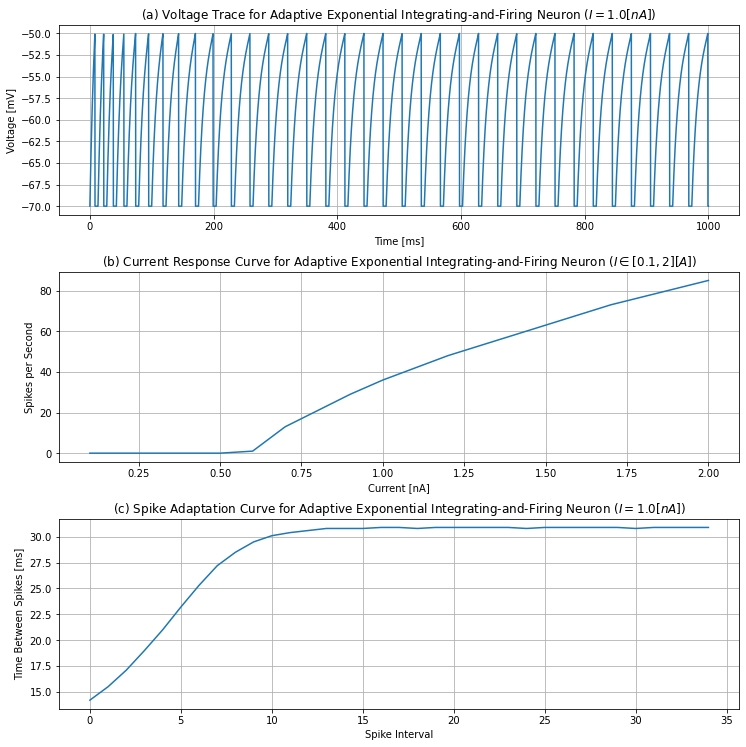

In [18]:
start_scope()
# Coming from https://infoscience.epfl.ch/record/97829, 
# I will aim to implement the adaptive exponential-integrate-and-fire model

# First thing I notice is that the neuron parameters are of a much smaller scale
# Will use their parameters for some Low-Conductivity neuron

# Initialize Neuron + Simulation Parameters
C = 281*pfarad
g_L = 30*nsiemens
g_i = 0.5*nsiemens
g_c = 0.5*nsiemens
E_leak = -70*mV
E_exc = 0*mV
E_inh = -75*mV
V_th = -50*mV
sharp = 2*mV
tau_w = 144*ms
a = 4*nsiemens
b = 0.0805*nA

V_res = -70*mV
I_ext = 1*nA
tau_ref = 5*ms

# Initialize Neuron Behaviour Equations
n_eq = '''
dv/dt = (1/C)*(-g_L*(v-E_leak) + g_L*sharp*exp((v - V_th)/sharp) - g_c*(v - E_exc) - g_i*(v - E_inh) - w + I_ext) : volt (unless refractory)
dw/dt = (1/tau_w)*(a*(v - E_leak) - w) : amp
'''
thresh = 'v > V_th'
reset = '''
v = V_res
w = w + b
'''
ref = 'tau_ref'

# Create Neuron and Initialize Voltage to the Reset Voltage
ens = NeuronGroup(1, n_eq, threshold=thresh, reset=reset, refractory=ref, method='heun')
ens.v = V_res

# Configure Probes to Track Neuron Properties
p_voltage = StateMonitor(ens, 'v', record=True)
p_spike = SpikeMonitor(ens)

# Create Reset Point for Repeated Tests
store('aeif init')

# Initialize Visualization Objects
fig, (pl1, pl2, pl3) = plt.subplots(3,1)
fig.subplots_adjust(top=2.5,right=1.7,wspace=0.3,hspace=0.3)    

# Simulate
run(1000*ms)

# Add Voltage Trace and Inter-Spike Timing Data to Plots
pl1.plot(p_voltage.t*1000,p_voltage.v[0]*1000)
pl3.plot(np.diff(p_spike.t)*1000)

# Perform Variable Current Testing
I_set = np.arange(0.1,2.1,0.1)*nA
spike_counts = np.zeros_like(I_set)
for I_i in range(len(I_set)):
    restore('aeif init') # Reset Probes
    I_ext = I_set[I_i]
    run(1000*ms)
    spike_counts[I_i] = p_spike.num_spikes

# Add Spike Response Data to Variable Current Plot
pl2.plot(I_set*1000000000,spike_counts)

# Set Plot Properties for Make Look Pretty :)
pl1.set(title="(a) Voltage Trace for Adaptive Exponential Integrating-and-Firing Neuron ($I=1.0[nA]$)",xlabel="Time [ms]",ylabel="Voltage [mV]")
pl2.set(title="(b) Current Response Curve for Adaptive Exponential Integrating-and-Firing Neuron ($I\in [0.1,2][A]$)",xlabel="Current [nA]",ylabel="Spikes per Second")
pl3.set(title="(c) Spike Adaptation Curve for Adaptive Exponential Integrating-and-Firing Neuron ($I=1.0[nA]$)",xlabel="Spike Interval",ylabel="Time Between Spikes [ms]")
pl1.grid(); pl2.grid(); pl3.grid()
plt.show()

# Question 2: Wilson Neuron
In his 1999 paper "Simplified dynamics of human and mammalian neocortical neurons", Wilson reduced the Hodgkin-Huxley model down to three coupled differential equations. He showed that this neuron model reproduced action potential dynamics and other electrophysiological measures without any artificial reset mechanisms.

- $\tau_v \frac{dv}{dt} = -(17.81 + 47.58v + 33.80v^2)(v - 0.48) - 26r(v + 0.95) - 13h(v + 0.95) + I_{ext}$
- $\tau_r \frac{dr}{dt} = -r + 1.29v + 0.79 + 3.30(V + 0.38)^2$
- $\tau_h \frac{dh}{dt} = -h + 11(v + 0.754)*(v + 0.69)$

where $v$ is voltage, $r$ is a recovery variable, and $h$ is a conductance variable.

- $\tau_v = 0.97$ms
- $\tau_r = 5.6$ms
- $\tau_H = 99.0$ms
- $dt = 0.05$ms

## 2.1 [2 points] Implement the Wilson Neuron.  Produce an action potential by injecting an external current (I=3 for 0.1ms). Plot voltage vs time. How does the shape of the action potential compare to observed electrophysiology?

#### Tips:
 - Units are weirdly defined in this model: ```v``` varies between $-0.9$ and $0.3$, and time constants are given in seconds. It's easiest to just make the state variables unitless (e.g.```dv/dt = ... : 1```)
 - set the simulation timestep using ```defaultclock.dt = 0.025*ms```
 - set initial conditions to keep the neuron from firing a transient spike at simulation startup:
  - $v_0=-0.75$
  - $r_0=0.2$
 - use ```v**2``` to write powers in an ```eqn=''' ... '''``` block, not ```v^2```
 - run the simulation long enough to observe the full recovery period

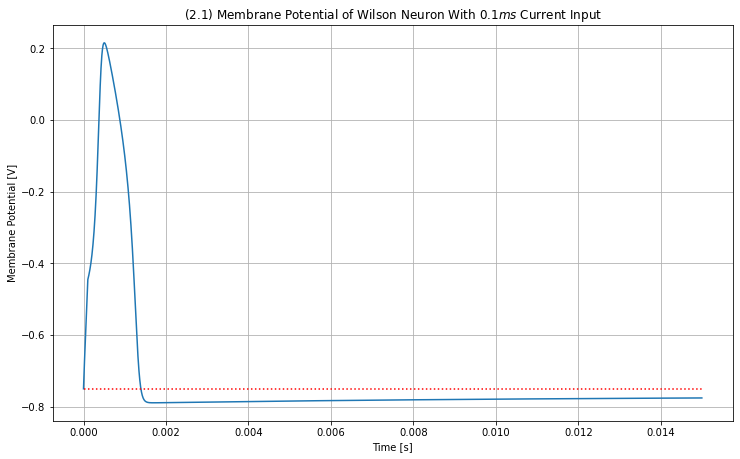

In [19]:
start_scope()

tau_v = 0.97*ms
tau_r = 5.60*ms
tau_h = 99.0*ms
v_o = -0.75
r_o = 0.2
I_ext = 3

eqn = '''
dv/dt = (1/tau_v) * (-(17.81 + 47.58*v + 33.80*v**2)*(v - 0.48) - 26*r*(v + 0.95) - 13*h*(v + 0.95) + I_ext) : 1
dr/dt = (1/tau_r) * (-r + 1.29*v + 0.79 + 3.30*(v + 0.38)**2) : 1
dh/dt = (1/tau_h) * (-h + 11*(v + 0.754)*(v + 0.69)) : 1
'''

defaultclock.dt = 0.005*ms
ens = NeuronGroup(1,eqn,method='heun')
ens.v = -0.75
ens.r = 0.2
p_voltage = StateMonitor(ens, 'v', record=True)
store ('wilson init')

run(0.1*ms)
I_ext = 0
run(14.9*ms)

fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(top=1.5,right=1.7,wspace=0.3,hspace=0.2)
pl1.plot(p_voltage.t,p_voltage.v[0])
pl1.hlines(-0.75,0,0.015,colors='r',linestyles='dotted')
pl1.set(title="(2.1) Membrane Potential of Wilson Neuron With $0.1ms$ Current Input",xlabel="Time [s]",ylabel="Membrane Potential [V]")
pl1.grid()
plt.show()

The shape of the action potential appears to be much more consistent with a typical observed electrophysiology. In contrast to the LIF models previously shown, there is a dip in membrane potential to below the "rest" voltage, as is typical when a biological neuron fires. Additionally, there isn't a piece-wise disjointedness to the membrane potential like in LIF simulations. The action potential appears to have a much more exponential shape to it once the input stimulus is taken away (notice the sharp exponential increase that is then replaced with a slower exponential increase just before the spike. Something additional worth noting is the slow, inversely exponential return to rest voltage that causes the membrane to have sub-rest potential for a substantial amount of time.

### 2.2 [1 point] Coupled ODEs in complex neuron models are numerically sensitive, and the system can explode under certain conditions. Show that increasing the timestep or injecting a powerful, sustained current produces unrealistic voltage traces.

WARNING    neurongroup_3's variable 'h' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_3's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_3's variable 'r' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


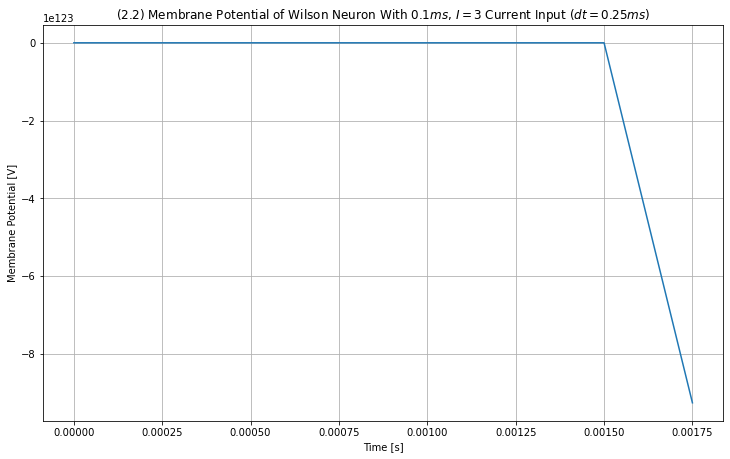

In [20]:
# Return to Initial Wilson state
restore('wilson init')

# Modify Timestep Information and Simulate
I_ext = 3
defaultclock.dt = 0.25*ms
run(0.1*ms)
I_ext = 0
run(99.9*ms)

# Visualize Voltage Results
fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(top=1.5,right=1.7,wspace=0.3,hspace=0.2)
pl1.plot(p_voltage.t,p_voltage.v[0])
pl1.set(title="(2.2) Membrane Potential of Wilson Neuron With $0.1ms$, $I=3$ Current Input ($dt=0.25ms$)",xlabel="Time [s]",ylabel="Membrane Potential [V]")
pl1.grid()
plt.show()

Evidently, increasing the simulation timestep from 0.025ms to 0.25ms has resulted in the membrane potential reaching $\approx -9*10^{123} [V]$. This seems likely unrealistic.

## 2.3 [1 point] Show the Wilson neuron exhibits spike adaptation by plotting ISI versus spike number. How does this adaptation compare to the adaptive LIF neuron from Question 1.3?

#### Note
- you will need to think of a good way to define a "spike" for continuous voltages

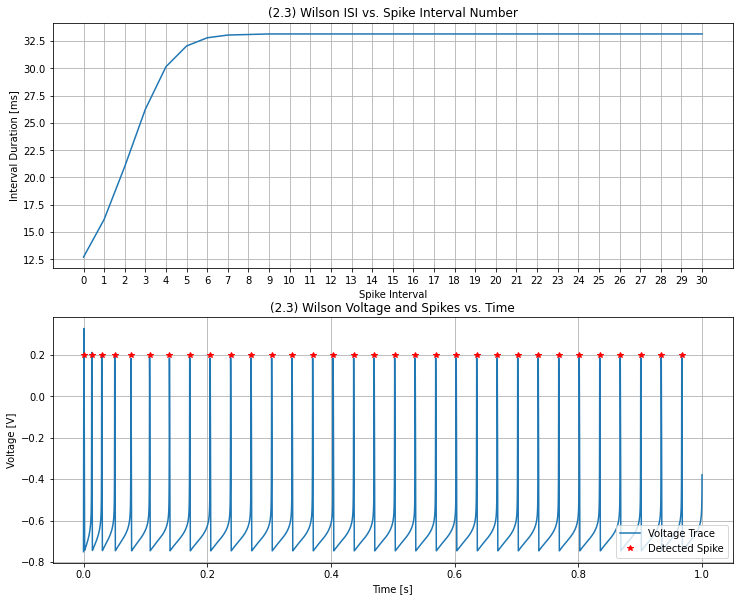

In [21]:
# For continuous voltages, we can consider there to be a "spike" when
# the voltage reaches a local maximum and drops to a lower voltage
from scipy import signal

# Return to Initial Wilson state
restore('wilson init')

# Modify Timestep Information and Simulate
defaultclock.dt = 0.05*ms
I_ext = 1
run(1000*ms)
relmax, _ = scipy.signal.find_peaks(p_voltage.v[0])

fig, (pl1, pl2) = plt.subplots(2,1)
fig.subplots_adjust(top=2.0,right=1.7,wspace=0.3,hspace=0.2)
#pl1.plot(p_voltage.v[0])
pl1.plot(np.diff(p_voltage.t[relmax])*1000)
pl1.set(title="(2.3) Wilson ISI vs. Spike Interval Number",xlabel="Spike Interval",ylabel="Interval Duration [ms]",xticks=np.arange(0,len(relmax)-1,1))
pl1.grid()

pl2.plot(p_voltage.t, p_voltage.v[0],label="Voltage Trace")
pl2.set(title="(2.3) Wilson Voltage and Spikes vs. Time",xlabel="Time [s]",ylabel="Voltage [V]")
pl2.plot(p_voltage.t[relmax],0.2*np.ones_like(p_voltage.t[relmax]),'*r',label="Detected Spike")
pl2.legend(loc="lower right")
pl2.grid()

This adaptation is very similar to the 1.3 adaptive LIF model based on the ISI vs. Spike Interval # plots for the two of them. This version has a much smoother curve, which is likely in part due to the Wilson model's continuous modeling compared to the adaptive LIF piecewise model. The Wilson model also displays a more logarithmic shape to the ISI plot, whereas the LIF model's ISI plot is more of an exponential. As a sidenote, the ISI plot for the Wilson model is actually very similar to that of the adaptive exponential LIF I implemented for 1.4. They have a very similar shape, though the Wilson model is significantly smoother.

# Intro to BRIAN2 (compartmental models)

BRIAN2 also support multicompartment models (https://brian2.readthedocs.io/en/stable/user/multicompartmental.html).  In addition to defining the equations governing the membrane dynamics (i.e. ion channels), building a compartmental neuron requires specifying a morphology. To do this, we'll use BRIAN2's pre-built sections

In [22]:
soma = Soma(diameter=30*um)  # defines a sphere

Attach new sections to a previously defined section like so

In [23]:
soma.axon = Cylinder(length=100*um, diameter=1*um, n=10)  # n=10 compartments in this section
soma.dendrite = Cylinder(length=50*um, diameter=2*um, n=5)
soma.dendrite.branch1 = Cylinder(length=10*um, diameter=1*um, n=3)
soma.dendrite.branch2 = Cylinder(length=10*um, diameter=1*um, n=3)

Now we can define a SpatialNeuron according to our biophysical equations. BRIAN will automatically solve the cable equation between all the compartments, so specifying $\frac{dv}{dt}$ and $\frac{d^2v}{dx^2}$ is unnecessary: the user only needs to define the transmembrane and external currents. Notice that physical constants and state variables are now defined relative to space.

In [24]:
gL = 1e-4*siemens/cm**2  # leak conductance
Cm = 1*uF/cm**2  # membrane capacitance
Ri = 100*ohm*cm  # longitudinal (intracellular) resistivity
EL = -70*mV  # leak reversal potential

eqn = '''
Im = gL * (EL - v) : amp/meter**2  # total ionic (membrance) current
I : amp (point current)  # external current
# dv/dt, d2v/dx2, and I_long are calculated automatically
'''

neuron = SpatialNeuron(morphology=soma, model=eqn, Cm=Cm, Ri=Ri)

Set the membrane voltage of all compartments to -65mV, then apply an external current a few specific compartments. Note the use of ```.main``` to target a specific compartment

In [25]:
neuron.v = EL + 10*mV  # applies to state variables in soma compartment AND all connected compartments
neuron.main.v = EL + 10*mV  # applies to state variables in soma compartment
neuron.main.I[0] = 1*nA  # applies only to soma
neuron.dendrite.I[3] = 0.5*nA  # applies to a compartment part way down the dendrite
neuron.dendrite.branch1.I[1] = 0.5*nA

To detect spikes, we'll add a threshold condition. To ensure that multiple spikes don't get registered if this condition remains true for a while (e.g. v>v_thr), we'll also specify a refractory condition.

In [26]:
neuron = SpatialNeuron(morphology=soma, model=eqn,
    threshold='v > 0*mV',
    threshold_location=neuron.main[0],
    refractory='v > 0*mV',
    method="exponential_euler")

# Question 3: Hodgkin Huxley Neurons

A template for the Hodgkin-Huxley model is provided below, including various physical constants and a simple morphology. Note that voltage has been rescaled to $v_{rest} = 0$mV, and the equations for the gating variables have shifted accordingly.

## 3.1 [2 points] Implement the Hodgkin-Huxley model by filling in the provided template. Plot voltage vs time and $m$, $n$, and $h$ versus time for an external input of ```1uA``` applied over ```3ms```. 

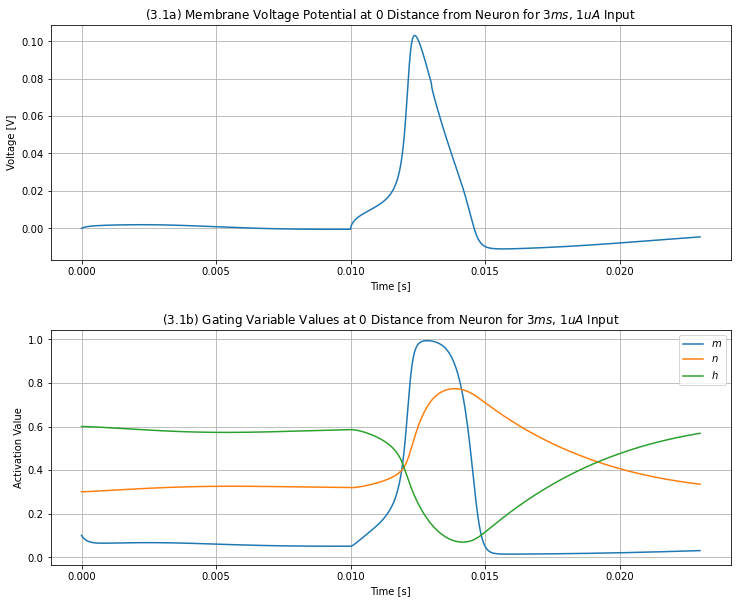

In [27]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

# Fill in these equations
eqn = '''
Im = g_leak * (E_leak - v) + g_na * m**3 * h * (E_na - v) + g_k * n**4 * (E_k - v) : amp/meter**2
dm/dt = alpha_m * (1 - m) - beta_m * m : 1
dn/dt = alpha_n * (1 - n) - beta_n * n : 1
dh/dt = alpha_h * (1 - h) - beta_h * h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

neuron = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.m = 0.1
neuron.n = 0.3
neuron.h = 0.6

v_neuron = StateMonitor(neuron, 'v', record=True)
m_neuron = StateMonitor(neuron, 'm', record=True)
n_neuron = StateMonitor(neuron, 'n', record=True)
h_neuron = StateMonitor(neuron, 'h', record=True)

defaultclock.dt = 0.01*ms

store('spatial init')

run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(10*ms)

fig, (pl1, pl2) = plt.subplots(2,1)
fig.subplots_adjust(top=2.0,right=1.7,wspace=0.3,hspace=0.3)
pl1.plot(v_neuron.t,v_neuron.v[0,:])
pl1.set(title='(3.1a) Membrane Voltage Potential at 0 Distance from Neuron for $3ms$, $1uA$ Input',xlabel='Time [s]',ylabel='Voltage [V]')
pl1.grid()

pl2.plot(m_neuron.t,m_neuron.m[0,:],label="$m$")
pl2.plot(n_neuron.t,n_neuron.n[0,:],label="$n$")
pl2.plot(h_neuron.t,h_neuron.h[0,:],label="$h$")
pl2.set(title='(3.1b) Gating Variable Values at 0 Distance from Neuron for $3ms$, $1uA$ Input',xlabel='Time [s]',ylabel='Activation Value')
pl2.legend()
pl2.grid()

## 3.2 [0.5 point] Show that the action potential propagates down the cable with minimal attenuation.
- (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.
- (b) increase the longitudinal resistance and show that the signal propagates slower. 

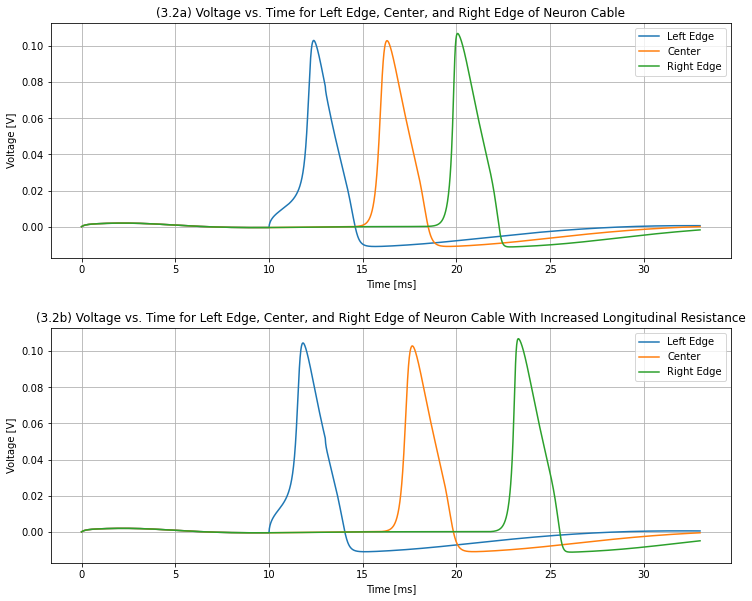

In [28]:
restore('spatial init')
run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(20*ms)

fig, (pl1, pl2) = plt.subplots(2,1)
fig.subplots_adjust(top=2.0,right=1.7,wspace=0.3,hspace=0.3)

pl1.plot(v_neuron.t*1000,v_neuron.v[0,:],label='Left Edge')
pl1.plot(v_neuron.t*1000,v_neuron.v[499,:],label='Center')
pl1.plot(v_neuron.t*1000,v_neuron.v[999,:],label='Right Edge')
pl1.set(title='(3.2a) Voltage vs. Time for Left Edge, Center, and Right Edge of Neuron Cable',xlabel='Time [ms]',ylabel='Voltage [V]')
pl1.legend()
pl1.grid()

restore('spatial init')
neuron.Ri = 75.8*ohm*cm
run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(20*ms)

pl2.plot(v_neuron.t*1000,v_neuron.v[0,:],label='Left Edge')
pl2.plot(v_neuron.t*1000,v_neuron.v[499,:],label='Center')
pl2.plot(v_neuron.t*1000,v_neuron.v[999,:],label='Right Edge')
pl2.set(title='(3.2b) Voltage vs. Time for Left Edge, Center, and Right Edge of Neuron Cable With Increased Longitudinal Resistance',xlabel='Time [ms]',ylabel='Voltage [V]')
pl2.legend()
pl2.grid()

We can clearly see that the spike's propagation through the culinder has minimal attenuation, as the peak remains consistently around $0.1[V]$. Increasing the longitudinal resistance, however, results in the spikes being spaced further apart, meaning that the increased longitudinal resistance caused an increase to the amount of time it takes for the action potential to propagate.

## 3.3 [0.5 point] Create a stimulus that produces a rebound spike, and plot the resulting voltage trace

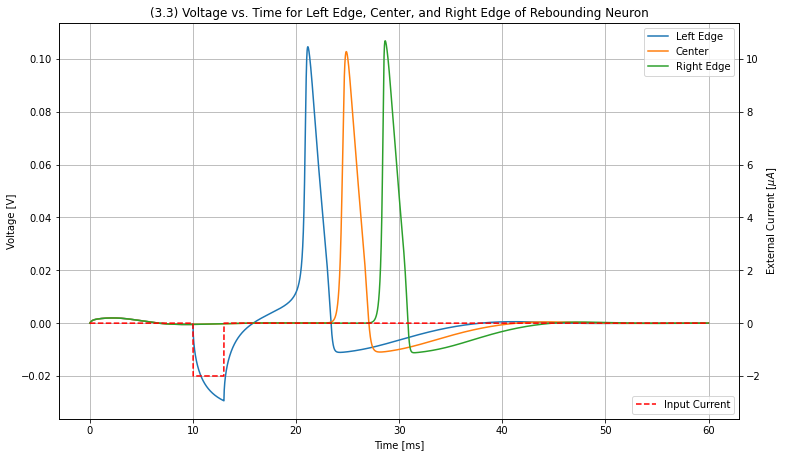

In [29]:
restore('spatial init')
run(10*ms)
neuron.I[0] = -2*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(47*ms)

fig, pl1 = plt.subplots(1,1)
fig.subplots_adjust(top=1.5,right=1.7,wspace=0.3,hspace=0.3)
pl2 = pl1.twinx()

pl1.plot(v_neuron.t*1000,v_neuron.v[0,:],label='Left Edge')
pl1.plot(v_neuron.t*1000,v_neuron.v[499,:],label='Center')
pl1.plot(v_neuron.t*1000,v_neuron.v[999,:],label='Right Edge')
pl1.set(title='(3.3) Voltage vs. Time for Left Edge, Center, and Right Edge of Rebounding Neuron',xlabel='Time [ms]',ylabel='Voltage [V]')
pl1.legend()
pl1.grid()

p1_yl = pl1.get_ylim()
p1_yl = np.multiply(p1_yl,100)
i_rec = np.zeros_like(v_neuron.t)
i_rec[1001:1300] = -2
pl2.plot(v_neuron.t*1000,i_rec,'r--',label='Input Current')
pl2.set(ylabel="External Current [$\mu A$]",ylim=p1_yl)
pl2.legend(loc='lower right')

## 3.4 [2 points] Create a new cell morphology that includes a soma and a dendritic tree with one branch. Show that voltage attenuation increases with the distance from the soma.
- Use ```Cylinder()``` for dendritic sections, with geometric parameters in these ranges:
 - ```length=10-100um```
 - ```diameter=0.1-1um```
 - ```n=5-100```
- Choose several points along the tree as injection sites.
- For each site, apply an identical external current ```I=100*pA``` and measure the resulting voltage change at the soma ($\Delta v = v_{rest} - v_{max}$).
- Plot $\Delta v$ vs distance. How does attenuation vary within a section and between sections (especially at branch points)?

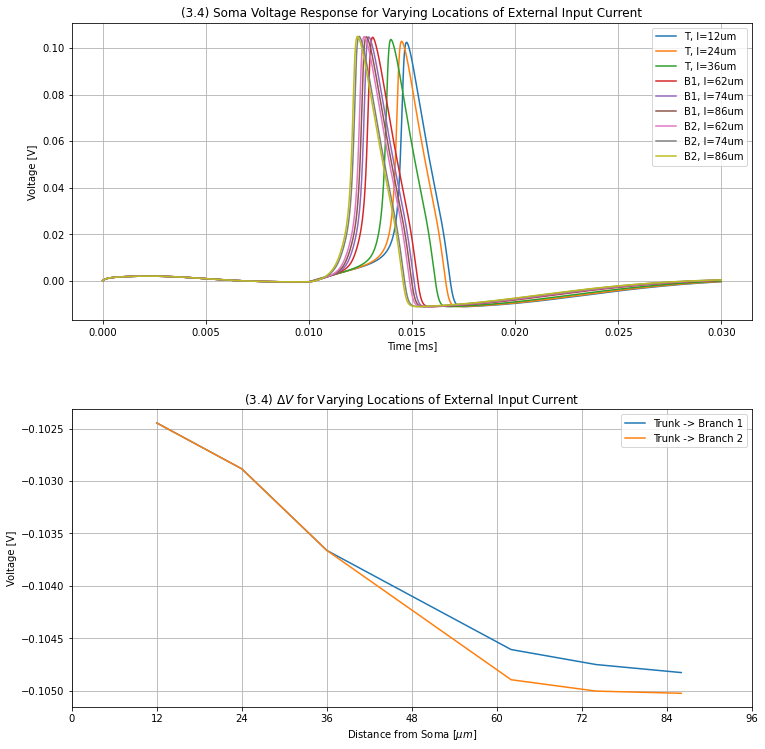

In [30]:
start_scope()

E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

soma = Soma(30*um) # Using same diameter as example above (not specified)
soma.dendrite = Cylinder(length=50*um,diameter=0.50*um,n=50)
soma.dendrite.b1 = Cylinder(length=50*um, diameter=0.50*um,n=50)
soma.dendrite.b2 = Cylinder(length=50*um, diameter=0.25*um,n=50)

eqn = '''
Im = g_leak * (E_leak - v) + g_na * m**3 * h * (E_na - v) + g_k * n**4 * (E_k - v) : amp/meter**2
dm/dt = alpha_m * (1 - m) - beta_m * m : 1
dn/dt = alpha_n * (1 - n) - beta_n * n : 1
dh/dt = alpha_h * (1 - h) - beta_h * h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

neuron = SpatialNeuron(morphology=soma, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.m = 0.1
neuron.n = 0.3
neuron.h = 0.6

v_neuron = StateMonitor(neuron, 'v', record=True)

defaultclock.dt = 0.01*ms
store('var dist init')
fig, (pl1, pl2) = plt.subplots(2,1)
fig.subplots_adjust(top=2.5,right=1.7,wspace=0.3,hspace=0.3)

# Record voltage traces and label them for later plotting
v_traces = []
v_labels = []

# Trunk:
for t_dist in [12, 24, 36]:
    restore('var dist init')
    run(10*ms)
    neuron.I[soma.dendrite[t_dist*um]] = 100*pA
    run(5*ms)
    neuron.I = 0*pA
    run(15*ms)
    v_traces.append(v_neuron[soma].v)
    v_labels.append(f"T, l={t_dist}um")
        
# Branch 1:
for b1_dist in [12, 24, 36]:
    restore('var dist init')
    run(10*ms)
    neuron.I[soma.dendrite.b1[b1_dist*um]] = 100*pA
    run(5*ms)
    neuron.I = 0*pA
    run(15*ms)
    v_traces.append(v_neuron[soma].v)
    v_labels.append(f"B1, l={b1_dist + 50}um")
    
# Branch 2:
for b2_dist in [12, 24, 36]:
    restore('var dist init')
    run(10*ms)
    neuron.I[soma.dendrite.b2[b2_dist*um]] = 100*pA
    run(5*ms)
    neuron.I = 0*pA
    run(15*ms)
    v_traces.append(v_neuron[soma].v)
    v_labels.append(f"B2, l={b2_dist + 50}um")
    

for plt_idx in range(len(v_traces)):
    pl1.plot(v_neuron.t, v_traces[plt_idx],label=v_labels[plt_idx])
    
pl1.set(title='(3.4) Soma Voltage Response for Varying Locations of External Input Current',xlabel='Time [ms]',ylabel='Voltage [V]')
pl1.legend()
pl1.grid()

v_max = np.squeeze(np.array(np.max(np.matrix(v_traces),1)))

b1_maxes = v_max[0:6]
b2_maxes = np.concatenate((v_max[0:3], v_max[6:]))

dists = [12, 24, 36, 62, 74, 86]
pl2.plot(dists,-b1_maxes,label="Trunk -> Branch 1")
pl2.plot(dists,-b2_maxes,label="Trunk -> Branch 2")
pl2.set(title='(3.4) $\Delta V$ for Varying Locations of External Input Current',xlabel='Distance from Soma [$\mu m$]',ylabel='Voltage [V]',xticks=np.arange(0,100,12))
pl2.legend()
pl2.grid()


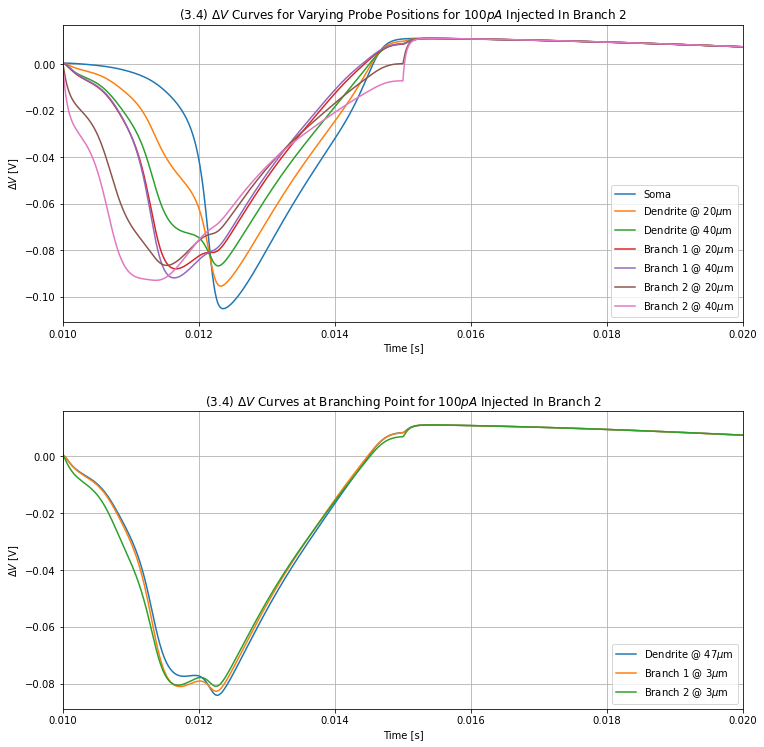

In [31]:
fig, (pl1,pl2) = plt.subplots(2,1)
fig.subplots_adjust(top=2.5,right=1.7,wspace=0.3,hspace=0.3)
pl1.plot(v_neuron.t,-v_neuron[soma].v,label="Soma")
pl1.plot(v_neuron.t,-v_neuron[soma.dendrite[20*um]].v,label="Dendrite @ 20$\mu$m")
pl1.plot(v_neuron.t,-v_neuron[soma.dendrite[40*um]].v,label="Dendrite @ 40$\mu$m")
pl1.plot(v_neuron.t,-v_neuron[soma.dendrite.b1[20*um]].v,label="Branch 1 @ 20$\mu$m")
pl1.plot(v_neuron.t,-v_neuron[soma.dendrite.b1[40*um]].v,label="Branch 1 @ 40$\mu$m")
pl1.plot(v_neuron.t,-v_neuron[soma.dendrite.b2[20*um]].v,label="Branch 2 @ 20$\mu$m")
pl1.plot(v_neuron.t,-v_neuron[soma.dendrite.b2[40*um]].v,label="Branch 2 @ 40$\mu$m")
pl1.set(title="(3.4) $\Delta V$ Curves for Varying Probe Positions for $100pA$ Injected In Branch 2",xlabel="Time [s]",ylabel="$\Delta V$ [V]", xlim=[0.01,0.02])
pl1.legend()
pl1.grid()

pl2.plot(v_neuron.t,-v_neuron[soma.dendrite[47*um]].v,label="Dendrite @ 47$\mu$m")
pl2.plot(v_neuron.t,-v_neuron[soma.dendrite.b1[3*um]].v,label="Branch 1 @ 3$\mu$m")
pl2.plot(v_neuron.t,-v_neuron[soma.dendrite.b2[3*um]].v,label="Branch 2 @ 3$\mu$m")
pl2.set(title="(3.4) $\Delta V$ Curves at Branching Point for $100pA$ Injected In Branch 2",xlabel="Time [s]",ylabel="$\Delta V$ [V]", xlim=[0.01,0.02])
pl2.legend()
pl2.grid()

Attenuation is the loss of action potential as it travels from the soma to the peripheral parts of the neuron -- such as axons and dendrites. In the above figure, we see $\Delta V$ responses from across the neuron when $100pA$ is injected $36\mu m$ along the second dendritic branch ($86\mu m$ from the soma). Rather apparent is the early increase to $\Delta V$ for points along Branch 2 and subsequently Branch 1 as the signal conducts through the cylinders. The neuron then spikes around $12.3ms$, and there is an apparent decrease in the magnitude of $\Delta V$ from the soma out to the branches. This is the result of actional potential attentuation that is caused by internal resistance to signal flow. This internal resistance is impacted both by the cell geometry and material properties.

Within a single section, we see that attentuation occurs as we move away from the source of potential. For the first plot, this is both the injected current ($36\mu m$ along Branch 2) and the spike (the soma). The second graph shows that there is minimal attenuation of potential at branching points, as probed values nearby all share a very similar value. This makes sense, as action potential is maintained along parallel connections.